## <center> *Модель прогнозирования стоимости жилья для агентства недвижимости*

# <center> **Часть II. Разведывательный анализ и моделирование.**

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.preprocessing as pp 
import sklearn.model_selection as ms 
import sklearn.feature_selection as fs

import sklearn.linear_model as lm
import sklearn.tree as tree
import sklearn.ensemble as ens
import sklearn.svm as svm
import sklearn.metrics as m

import lightgbm as lgbm
import xgboost as xgb
import catboost as cb 

from functions import *
import pickle 

import warnings
warnings.filterwarnings('ignore')

plt.style.use('bmh')

R = 314
np.random.seed(R)

## **Данные**

Читаем данные

In [2]:
data = pd.read_csv('data/data_edited.csv')

data

,status for sale,status coming soon,status new,status foreclosure,status pre-foreclosure,status pending,status auction,status active,status show,status for rent,...,school distance mean,school rating nearest,school distance to best,schools with k,schools with pk,schools with preschool,school grades,target per month,target plus,target
0,0,0,0,0,0,0,0,1,0,0,...,5.54,7,5.10,3,2,0,13,0,0,418.000
1,1,0,0,0,0,0,0,0,0,0,...,1.33,4,1.65,1,1,0,13,0,0,310.000
2,1,0,0,0,0,0,0,0,0,0,...,1.96,8,1.19,1,0,0,13,0,0,2895.000
3,1,0,0,0,0,0,0,0,0,0,...,0.75,9,1.05,1,1,0,13,0,0,2395.000
4,1,0,0,0,0,0,0,0,0,0,...,4.08,4,3.25,1,1,0,13,0,0,5.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360187,1,0,0,0,0,0,0,0,0,0,...,0.25,3,0.40,1,1,0,13,0,0,799.000
360188,0,0,0,0,0,0,0,0,0,0,...,16.60,10,32.10,1,1,0,13,0,0,1249.000
360189,1,0,0,0,0,0,0,0,0,0,...,4.14,1,0.40,1,1,0,13,0,0,674.999
360190,1,0,0,0,0,0,0,0,0,0,...,0.60,4,0.48,1,1,0,9,0,0,528.000


## **Разведывательный анализ**

В наших данных присутствуют переменные следующих видов:
- **Бинарные** - где присутствуют только два значения, 0 и 1.
- **Категориальные** - целочисленные и имеют четко определенный набор значений.
- **Непрерывные** - имеют большое количество уникальных значений, иногда дробных.

Обработаем каждый вид по порядку.

### Исследование бинарных переменных

Бинарные переменные располагаются по группам, каждая группа обозначена некоторым словом. Следовательно все остальные переменные являются числовыми.

In [3]:
# если в столбце присутствуют всего 2 значения - это бинарный признак, 
# добавляем во множество только слово, обозначающее группу переменнных. 
bin_cols = set()

# Остальные добавляем в список числовых признаков.
num_cols = []

for col in data.columns:
    if data[col].nunique() == 2:
        bin_cols.add(col.split()[0])
    else:
        num_cols.append(col)


bin_cols, num_cols

({'cooling', 'heating', 'parking', 'propertyType', 'status', 'target'},
 ['baths',
  'beds',
  'sqft area',
  'property age',
  'property remodeled',
  'p. spaces',
  'lotsize',
  'zipcode national area',
  'zipcode sectional center',
  'zipcode delivery area',
  'city importance',
  'city population rank',
  'school rating sum',
  'school rating mean',
  'school distance nearest',
  'school distance mean',
  'school rating nearest',
  'school distance to best',
  'schools with k',
  'schools with pk',
  'schools with preschool',
  'school grades',
  'target'])

> Пожалуй начнем Разведывательный анализ с выбросов.

### Выявление и очистка выбросов 

Выбросы негативно сказываются на обучении модели, так что они нам не нужны.

Shape of cleaned data is (305352, 151).
54840 outliers were dropped.


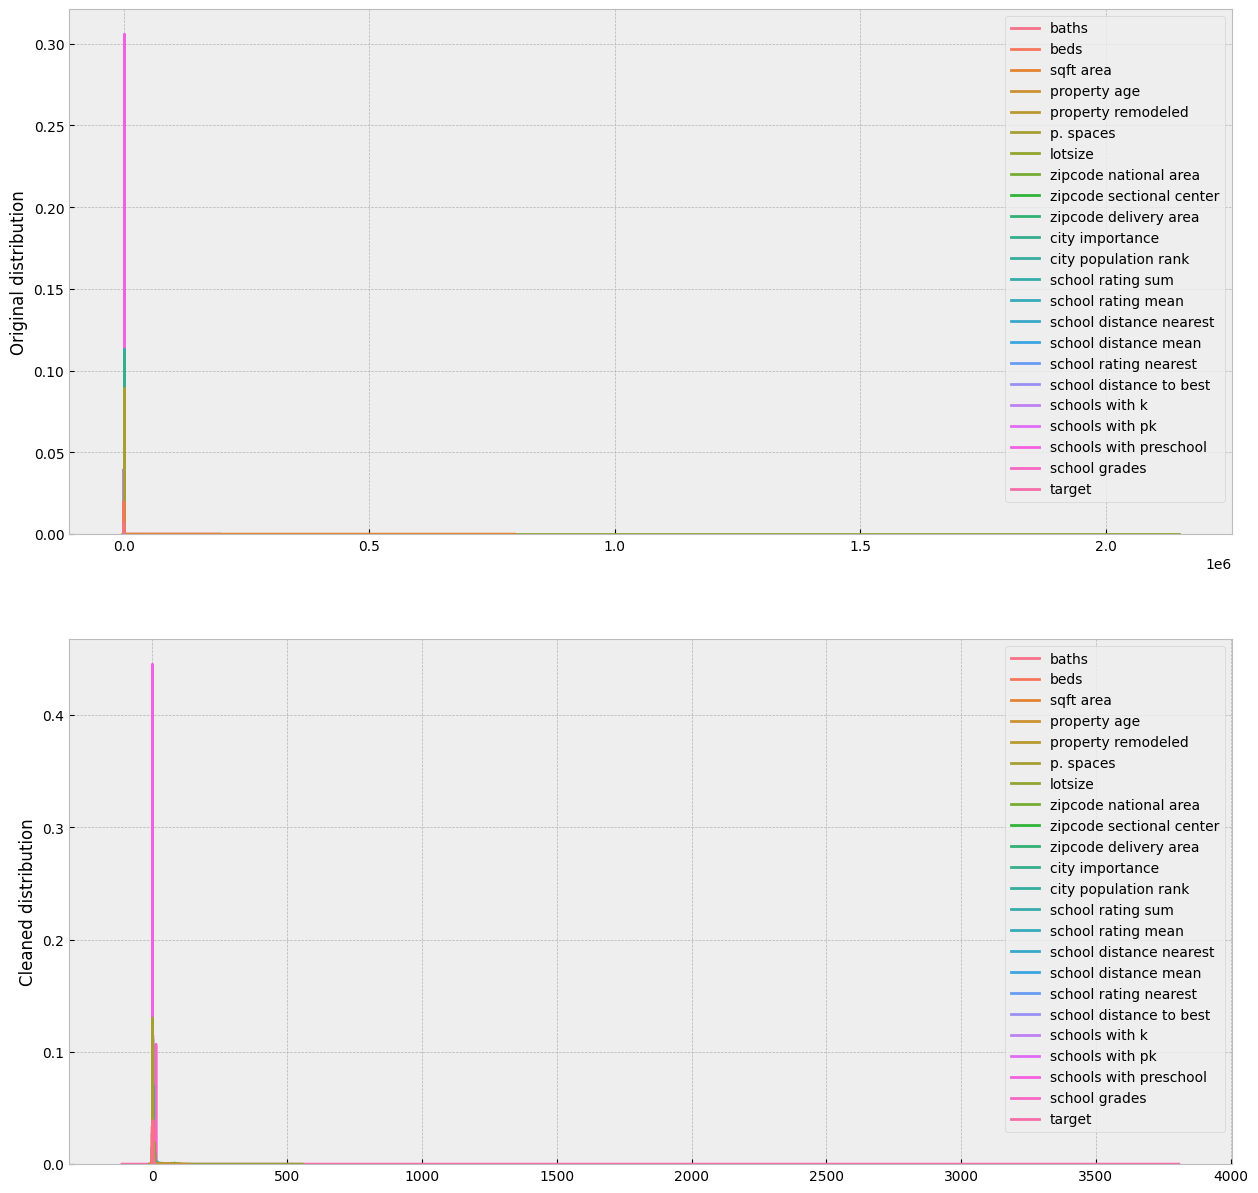

In [4]:
def clean_data(features, data=data, q_limit=0.99, show_plot=False):
    """ 
    Чистит данные от выбросов с помощью квантилей
    и выводит графики старых и новых данных, при необходимости.
    
    - features: признаки, которые нужно очистить
    - data: данные
    - q_limit: квантиль (процент, в рамках которого находятся данные)
    - show_plot: показать графики старых и новых данных
    """
    # по умолчанию берем квантиль, в которой находится 99% данных, 
    # все что за ее пределами - выбросы, чистим каждый столбец по отдельности
    cleaned = data.copy()
    
    for feature in features:
        x = cleaned[feature]
        
        lim = x.quantile(q_limit)
        cleaned = cleaned[x <= lim][x >= -lim].reset_index(drop=True)
    
    # сообщение о проделанной очистке
    print(f'Shape of cleaned data is {cleaned.shape}.')
    print(f'{data.shape[0] - cleaned.shape[0]} outliers were dropped.')
    
    # выводим график, если это необходимо
    if show_plot:
        fig, ax = plt.subplots(2, 1, figsize=(15, 15))
        
        sns.kdeplot(data[features], ax=ax[0])
        ax[0].set_ylabel('Original distribution')

        sns.kdeplot(cleaned[features], ax=ax[1])
        ax[1].set_ylabel('Cleaned distribution')

        fig.show()
    
    return cleaned


data = clean_data(num_cols, show_plot=True)

> В ходе очистки данных, было найдено более **54 тысяч** выбросов! На графиках видно, что масштаб сильно изменился. Кроме этого, второй график пока ни о чем не говорит, так как признаки сами по себе имеют разные масштабы, поэтому их необходимо **масштабировать** (но данный этап будет чуть дальше).

### Проверка на мультиколлинеарность

Сильно коррелирующие признаки по сути дублируют друг друга и потому приводят к переобучению, от них тоже нужно избавиться.

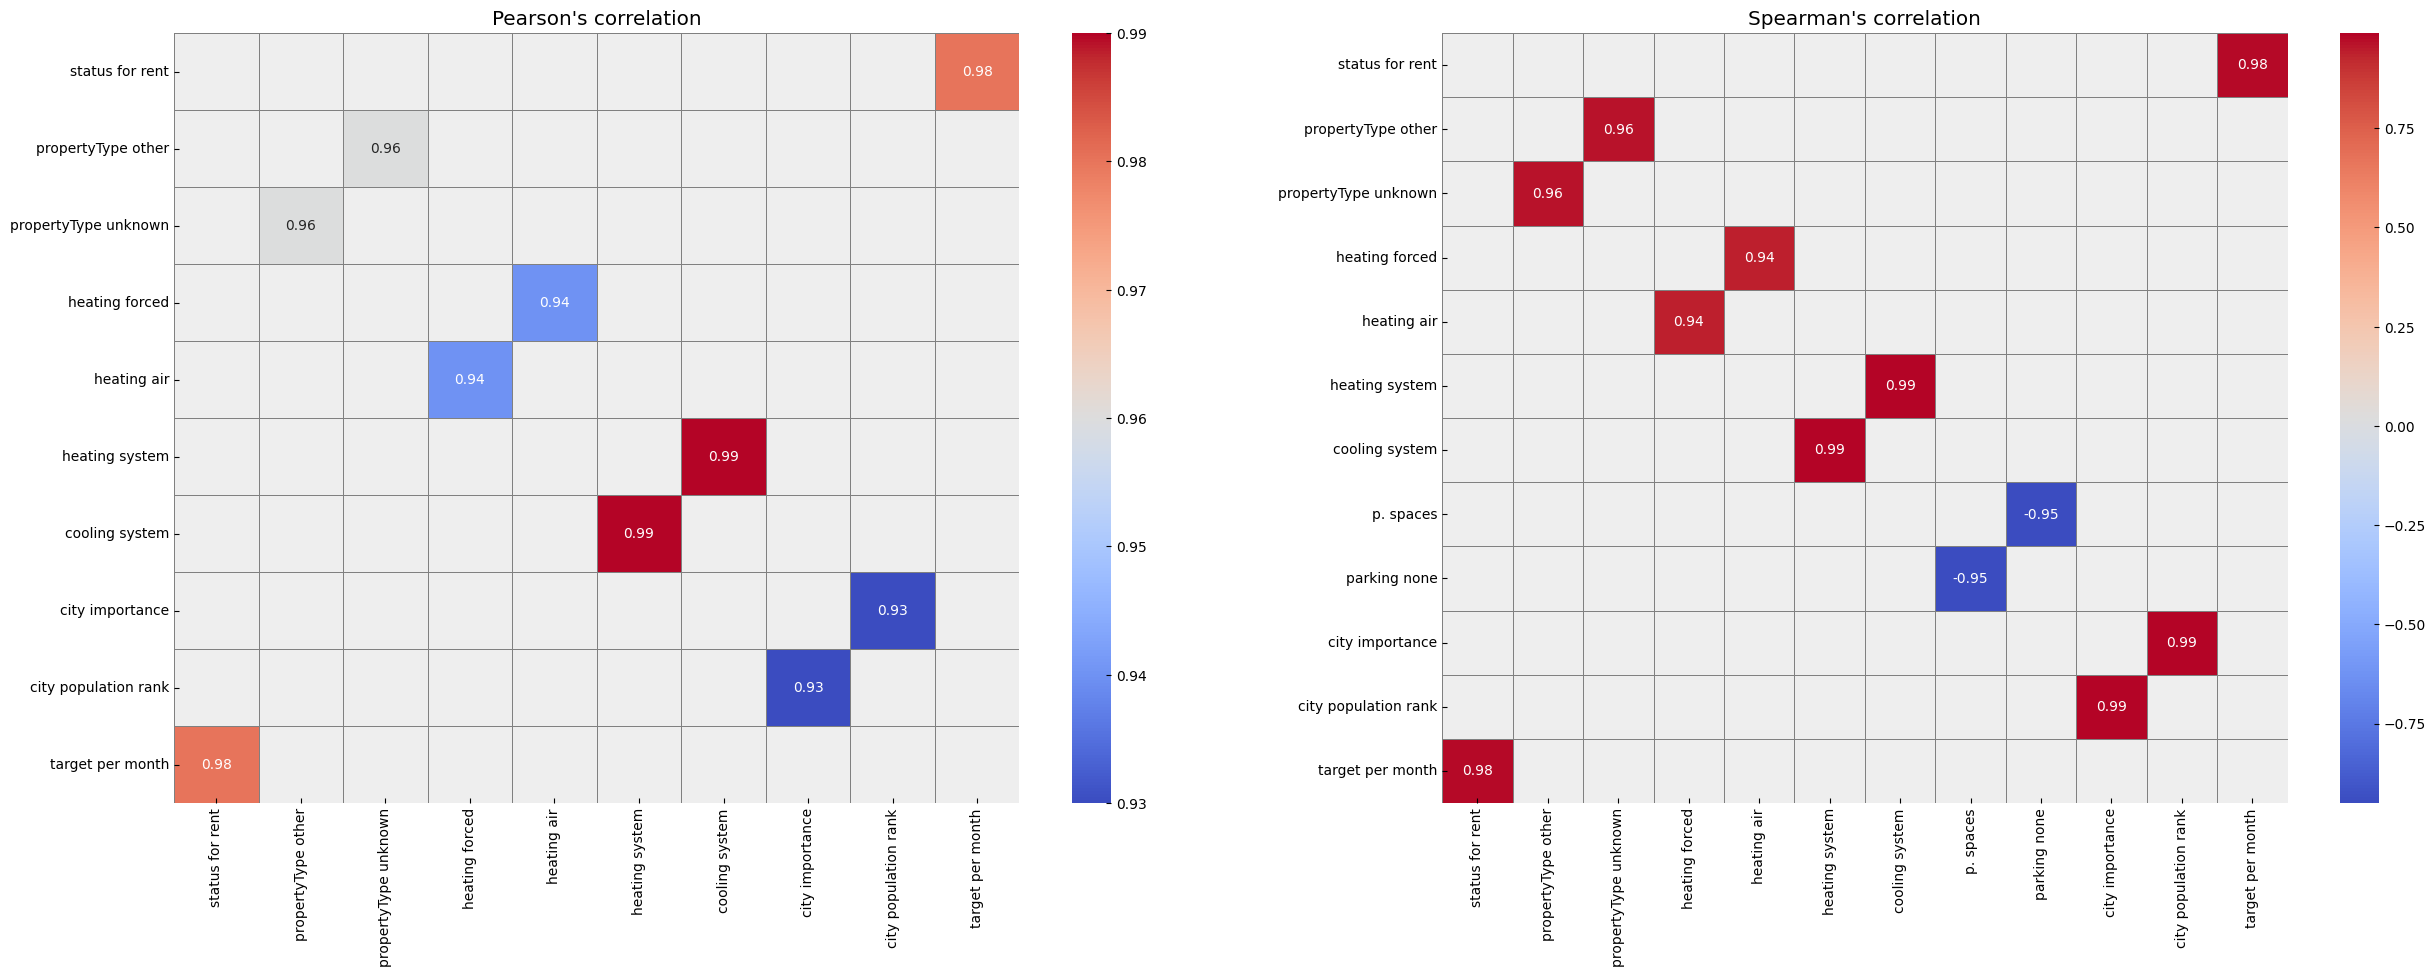

In [5]:
# так как признаков в данных очень много, простая коррелограмма будет очень сложной и неинформативной, 
# поэтому для графика выделим только мультиколлинеарные признаки, а для этого создадим функцию

def get_correlations(method, data=data):
    """ 
    Вычисляет коррелограмму данных и выделяет только 
    сильно коррелирующие между собой признаки.
    
    - method: метод вычисления корреляции - Пирсона, Спирмена или Кендалла
    - data: данные
    """
    # вычисляем корреляции и выделяем только признаки с 
    # показателем выше 0.9 и округляем до 2 знаков для удобства
    corr_data = (data.corr(method=method)
                 [data.corr(method=method).abs() > 0.9]
                 .round(2))

    # на коррелограмме присутствует диагональ из единиц, так как
    # это корреляция признака с самим собой, заменяем единицы пропусками
    for i in corr_data.index:
        for c in corr_data.columns:
            if i == c:
                corr_data.loc[i, c] = np.nan

    # если суммы строк и столбцов равны нулю, удалим их из данных,
    # в итоге остаются только признаки с сильной корреляцией
    for i, c in zip(corr_data.index, 
                    corr_data.columns):
        if corr_data.loc[i].sum() == 0:
            corr_data.drop(i, axis=0, inplace=True)
        if corr_data.loc[:, c].sum() == 0:
            corr_data.drop(c, axis=1, inplace=True)
            
    return corr_data


# строим 2 графика по 2 видам корреляции, 
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

# для категориальных (в том числе и бинарных) - подходит метод Пирсона
sns.heatmap(get_correlations('pearson'), 
            annot=True, 
            cmap='coolwarm', 
            linewidths=.5, 
            linecolor='grey', 
            ax=ax[0])
ax[0].set_title("Pearson's correlation")

# для непрерывных - импользуем метод Спирмена
sns.heatmap(get_correlations('spearman'), 
            annot=True, 
            cmap='coolwarm', 
            linewidths=.5, 
            linecolor='grey', 
            ax=ax[1])
ax[1].set_title("Spearman's correlation")
    
fig.show()

> * Сильно коррелируют друг с другом дома сдаваемые в аренду и с ценой, указанной в месяц. 
> * Очень похожи признаки типов недвижимости, помеченных как пропуски и не попавших ни в одну категорию, что говорит о том, что на этапе обработки удалось выделить максимальное число категорий недвижимости. 
> * Отопление воздушное и усиленное - это по сути одно и то же, оно так и называется "heating air forced". 
> * Системное отопление можно переключить на охлаждение. Важность города зависит от численности населения. 
> * И наконец, дома, не имеющие паркинга - не имеют ни одного парковочного места. С данными выводами сложно не согласиться. 

In [6]:
# выбираем нужные столбцы и удаляем их 
multicollinear_cols = ['propertyType unknown', 'heating forced', 
                       'cooling system', 'parking none', 
                       'city importance', 'status for rent']

data.drop(multicollinear_cols, axis=1, inplace=True)

data.shape 

(305352, 145)

### Исследования по выборкам

Моя идея состоит в том, что каждая бинарная переменная по сути делит датасет на 2 части, где объекты либо имеют определенный признак, либо не имеют его. Следовательно нужно узнать, как зависит целевая переменная от этого признака и зависит ли вообще. Поскольку мы имеем **две** выборки и эти выборки **независимы**, мы будем использовать **U-критерий Манна-Уитни**. 

In [7]:
def binary_stattest(data, alpha=0.05):
    """
    Исследует две независимых выборки на предмет того,
    зависит ли от них распределение в целевом признаке
    
    - data: данные
    - alpha: уровень значимости
    """
    # выделяем бинарные столбцы
    bins_list = []

    for col in data.columns:
        if data[col].nunique() == 2:
            bins_list.append(col)
    
    # создаем новую таблицу с индексами-названиями
    statdata = pd.DataFrame(index=bins_list)
    pv_list = []
    dep_list = []
    
    # делим данные по бинарному признаку и применяем тест к целевым переменным
    for col_ in bins_list:
        sample_1 = data[data[col_] == 1]
        sample_0 = data[data[col_] == 0]
        
        _, p = sps.mannwhitneyu(sample_0['target'], 
                                sample_1['target'])
        pv_list.append(p)
        
        # если p-value больше уровня значимости, распределение в обеих выборках одинаковое
        # иначе, целевой признак зависит от выборки
        if p > alpha:
            dep_list.append(0)
        else:
            dep_list.append(1)
    
    # столбцы новой таблицы
    statdata['pvalue'] = pv_list
    statdata['depends'] = dep_list
    
    return statdata


bs_data = binary_stattest(data)

# выделяем бесполезные переменные, которые не влияют на целевой признак
useless_df = bs_data[bs_data['depends'] == 0]

useless_df

,pvalue,depends
propertyType cluster,0.575153,0
propertyType residential,0.669761,0
propertyType florida,0.080361,0
propertyType frame,0.590285,0
propertyType cabin,0.852571,0
heating gas,0.966599,0
heating heat pump,0.123656,0
heating baseboard,0.280441,0
heating stove,0.698046,0
heating refrigeration,0.216059,0


In [8]:
# удаляем бесполезные переменные
data.drop(useless_df.index, axis=1, inplace=True)

data.shape

(305352, 125)

### Исследование числовых переменных

В числовых переменных есть переменные **категориальные** и **непрерывные**. 

In [9]:
# проверим сколько уникальных значений есть в числовых признаках
num_cols = []

for col in data.columns:
    if data[col].nunique() > 2:
        num_cols.append(col)

# убираем целевую переменную, ее трогать пока нельзя
num_cols.remove('target')

numdata_info = get_data_info(data[num_cols])

numdata_info

,Nulls,Uniques,Dtypes
baths,0.0,9,int64
beds,0.0,8,int64
sqft area,0.0,6515,float64
property age,0.0,125,int64
property remodeled,0.0,99,int64
p. spaces,0.0,5,int64
lotsize,0.0,14917,float64
zipcode national area,0.0,10,int64
zipcode sectional center,0.0,94,int64
zipcode delivery area,0.0,93,int64


> Для выделения категориальных переменных, возьмем те столбцы, которые имеют до 20 уникальных значений.

#### *Категориальные*

In [10]:
# список категориальных переменных
cat_cols = (numdata_info
            .query('Uniques <= 20')
            .index).tolist()

cat_cols

['baths',
 'beds',
 'p. spaces',
 'zipcode national area',
 'city population rank',
 'school rating nearest',
 'schools with k',
 'schools with pk',
 'schools with preschool',
 'school grades']

> Проверим, как различаются выборки целевой переменной в зависимости от некотрой категории в получившихся переменных. Поскольку выборок получается **много** и они также **независимы**, используем для этого **тест Краскела-Уолиса**.

In [11]:
def multiple_stattest(data, cols=cat_cols, alpha=0.05):
    """ 
    Исследует несколько независимых выборок на предмет
    зависимости целевой переменной от них.
    
    - data: данные
    - cols: названия столбцов
    - alpha: уровень значимости
    """
    # новая таблица с индексами-названиями
    statdata = pd.DataFrame(index=cols)
    pv_list = []
    dep_list = []
    
    # создаем список из выборок
    for c in cols:
        samples = []

        # фильтруем данные по каждому уникальному значению,
        # добавляем выбрку в список и вычисляем p-value
        for i in data[c].unique():
            sample = data[data[c] == i]
            samples.append(sample['target'])
        
        _, p = sps.kruskal(*samples)
        pv_list.append(p)
        
        # если p-value меньше уровня значимости, распределение везде одинаковое, 
        # иначе - целевая переменная зависит от выборки
        if p > alpha:
            dep_list.append(0)
        else:
            dep_list.append(1)
            
    statdata['pvalue'] = pv_list
    statdata['depends'] = dep_list
    
    return statdata


multiple_stattest(data)

,pvalue,depends
baths,0.0,1
beds,0.0,1
p. spaces,0.0,1
zipcode national area,0.0,1
city population rank,0.0,1
school rating nearest,0.0,1
schools with k,0.0,1
schools with pk,0.0,1
schools with preschool,0.0,1
school grades,0.0,1


> Проведенные тесты показали, что среди категориальных переменных бесполезных признаков нет.

#### *Непрерывные*

In [12]:
# все остальные числовые переменные - по факту непрерывные
for cat in cat_cols:
    num_cols.remove(cat)
    
num_cols, len(num_cols) 

(['sqft area',
  'property age',
  'property remodeled',
  'lotsize',
  'zipcode sectional center',
  'zipcode delivery area',
  'school rating sum',
  'school rating mean',
  'school distance nearest',
  'school distance mean',
  'school distance to best'],
 11)

> С помощью статистических тестов исследовать их не получится, зато их можно проверить на нормальность или визуально оценить зависимость от целевого признака на точечной диаграмме.

In [13]:
def test_normality(labels, 
                   data=data, 
                   testfunc='shapiro', 
                   alpha=0.05):
    """
    Проверяет признаки на нормальность распределения.
    
    - labels: названия признаков.
    - data: таблица с данными.
    - testfunc: статистический тест на нормальность - Шапиро или Дагостино
    - alpha: уровень статистической значимости
    """
    # таблица, содержащая названия признаков в качестве индексов, значения p-value 
    # и признак, указывающий, является ли распределение признака нормальным
    norm_df = pd.DataFrame(index=labels)
    
    # применяем тест к каждому столбцу изначальной таблицы, 
    # выделяем p-value и добавляем в список
    pv_list = []
    for col in data[labels].columns:
        x = data[col]
        
        if testfunc == 'dagostino':
            p = sps.normaltest(x)
            pv = round(p.pvalue[0], 3)
            alpha = alpha / 2

        p = sps.shapiro(x)
        pv = round(p.pvalue, 3)
        
        pv_list.append(pv)
    
    # если p-value больше уровня значимости, распределение нормальное, иначе - нет
    norm_df['p_value'] = pv_list
    norm_df['is_normal'] = norm_df['p_value'].apply(lambda pv: 'normal' if pv > alpha else 'not normal')

    return norm_df


test_normality(num_cols)

,p_value,is_normal
sqft area,0.0,not normal
property age,0.0,not normal
property remodeled,0.0,not normal
lotsize,0.0,not normal
zipcode sectional center,0.0,not normal
zipcode delivery area,0.0,not normal
school rating sum,0.0,not normal
school rating mean,0.0,not normal
school distance nearest,0.0,not normal
school distance mean,0.0,not normal


> Ни в одном непрерывном признаке распределение не является нормальным. Посмотрим, что скажут точечные диаграммы.

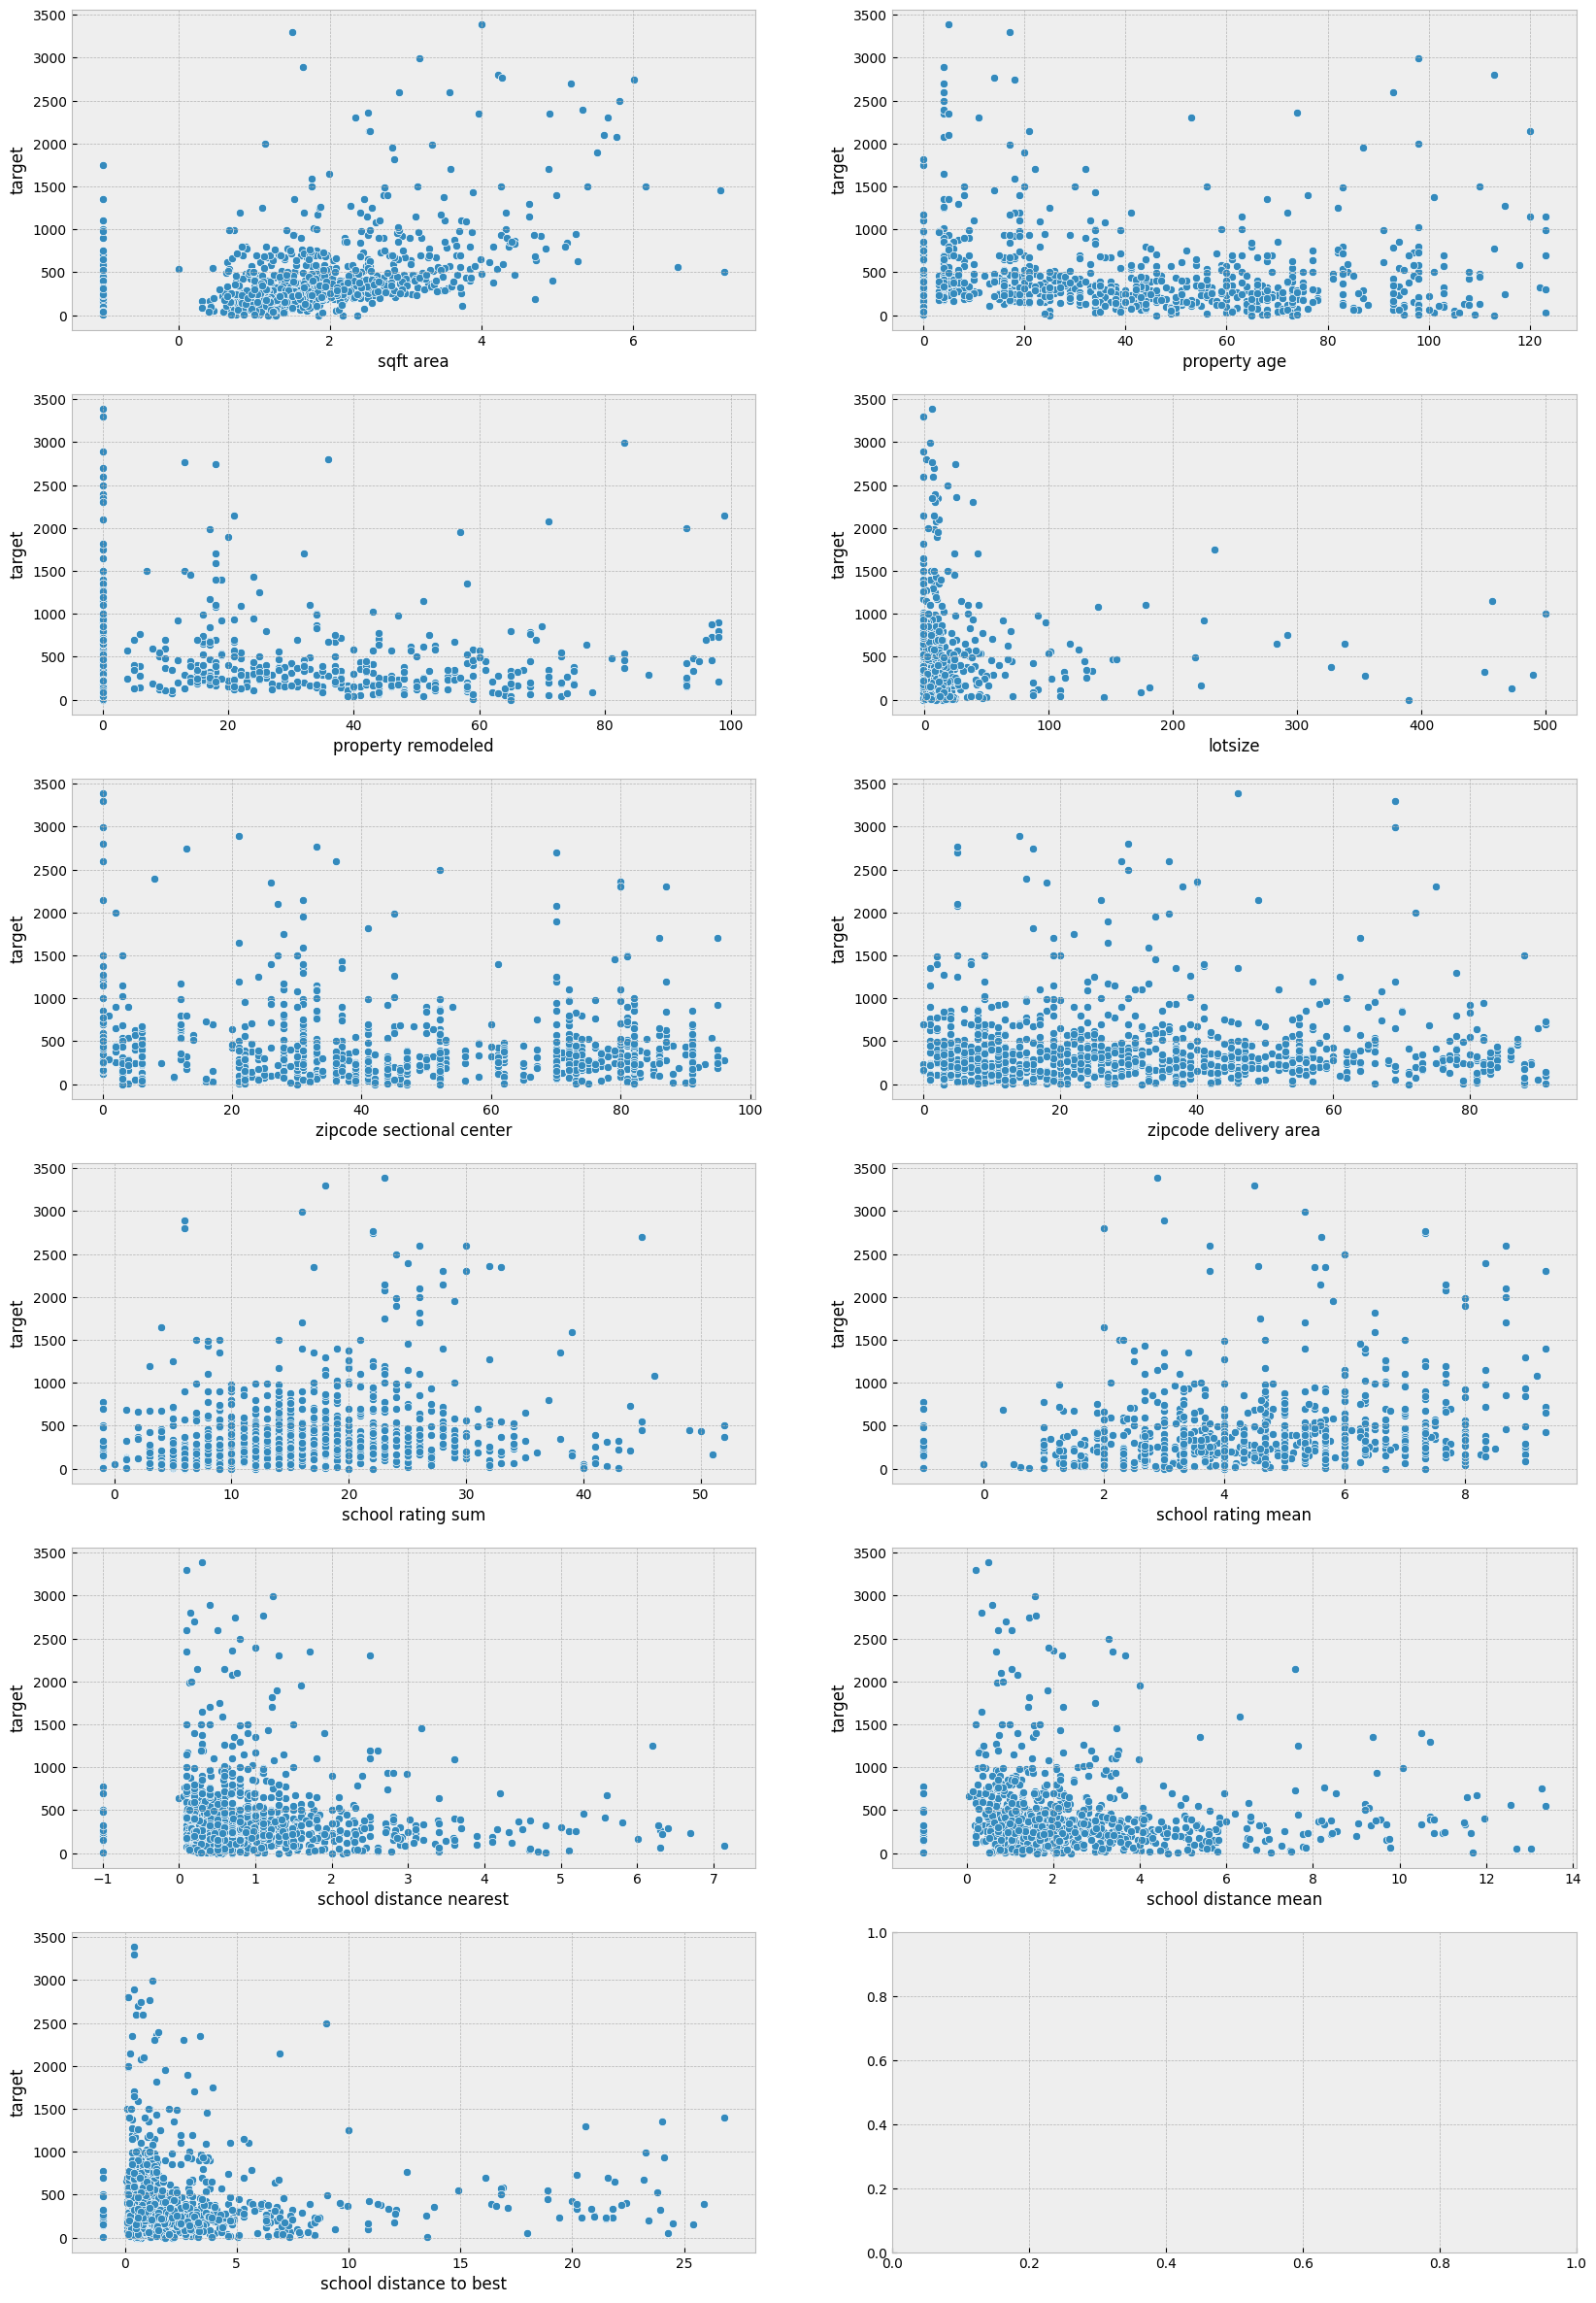

In [14]:
fig, ax = plt.subplots(6, 2, figsize=(20, 30))

# поскольку данных очень много, диаграммы будут сложными и неинформативными,
# поэтому выберем 1000 случайных объектов и с ними построим графики
for i, col in enumerate(num_cols):
    sample = data[[col, 'target']].sample(1000, random_state=R)

    # если номер элемента списка четный, размещаем график в первой колонке фигуры
    # иначе - во второй колонке 
    if i % 2 == 0:
        ax_place = ax[i//2, 0]
    else:
        ax_place = ax[i//2, 1]
        
    sns.scatterplot(sample, x=col, y='target', ax=ax_place)
    
fig.show()

> * Цена почти экспоненциально возрастает с возрастанием площади жилья.
> * В признаках возраста здания, лет с момента реконструкции и почтовых индексов значения сконцентрированы ниже отметки в 1 млн. долларов.
> * Размер участка как правило не превышает 50 тыс. квадратных футов. 
> * Цена в зависимости от рейтинга школ рядом линейно возростает.
> * Расстояния до школ сконцентрированы в треугольнике с вершинами на отметках X=10 и Y=1500.

### Масштабирование данных

Теперь необходимо привести данные к единому стандарту. Поскольку данные от выбросов мы уже очистили, а большинство переменных бинарные, лучшим способом масштабирования я считаю **MinMaxScaler**, который приведет данные в масштаб от 0 до 1. 

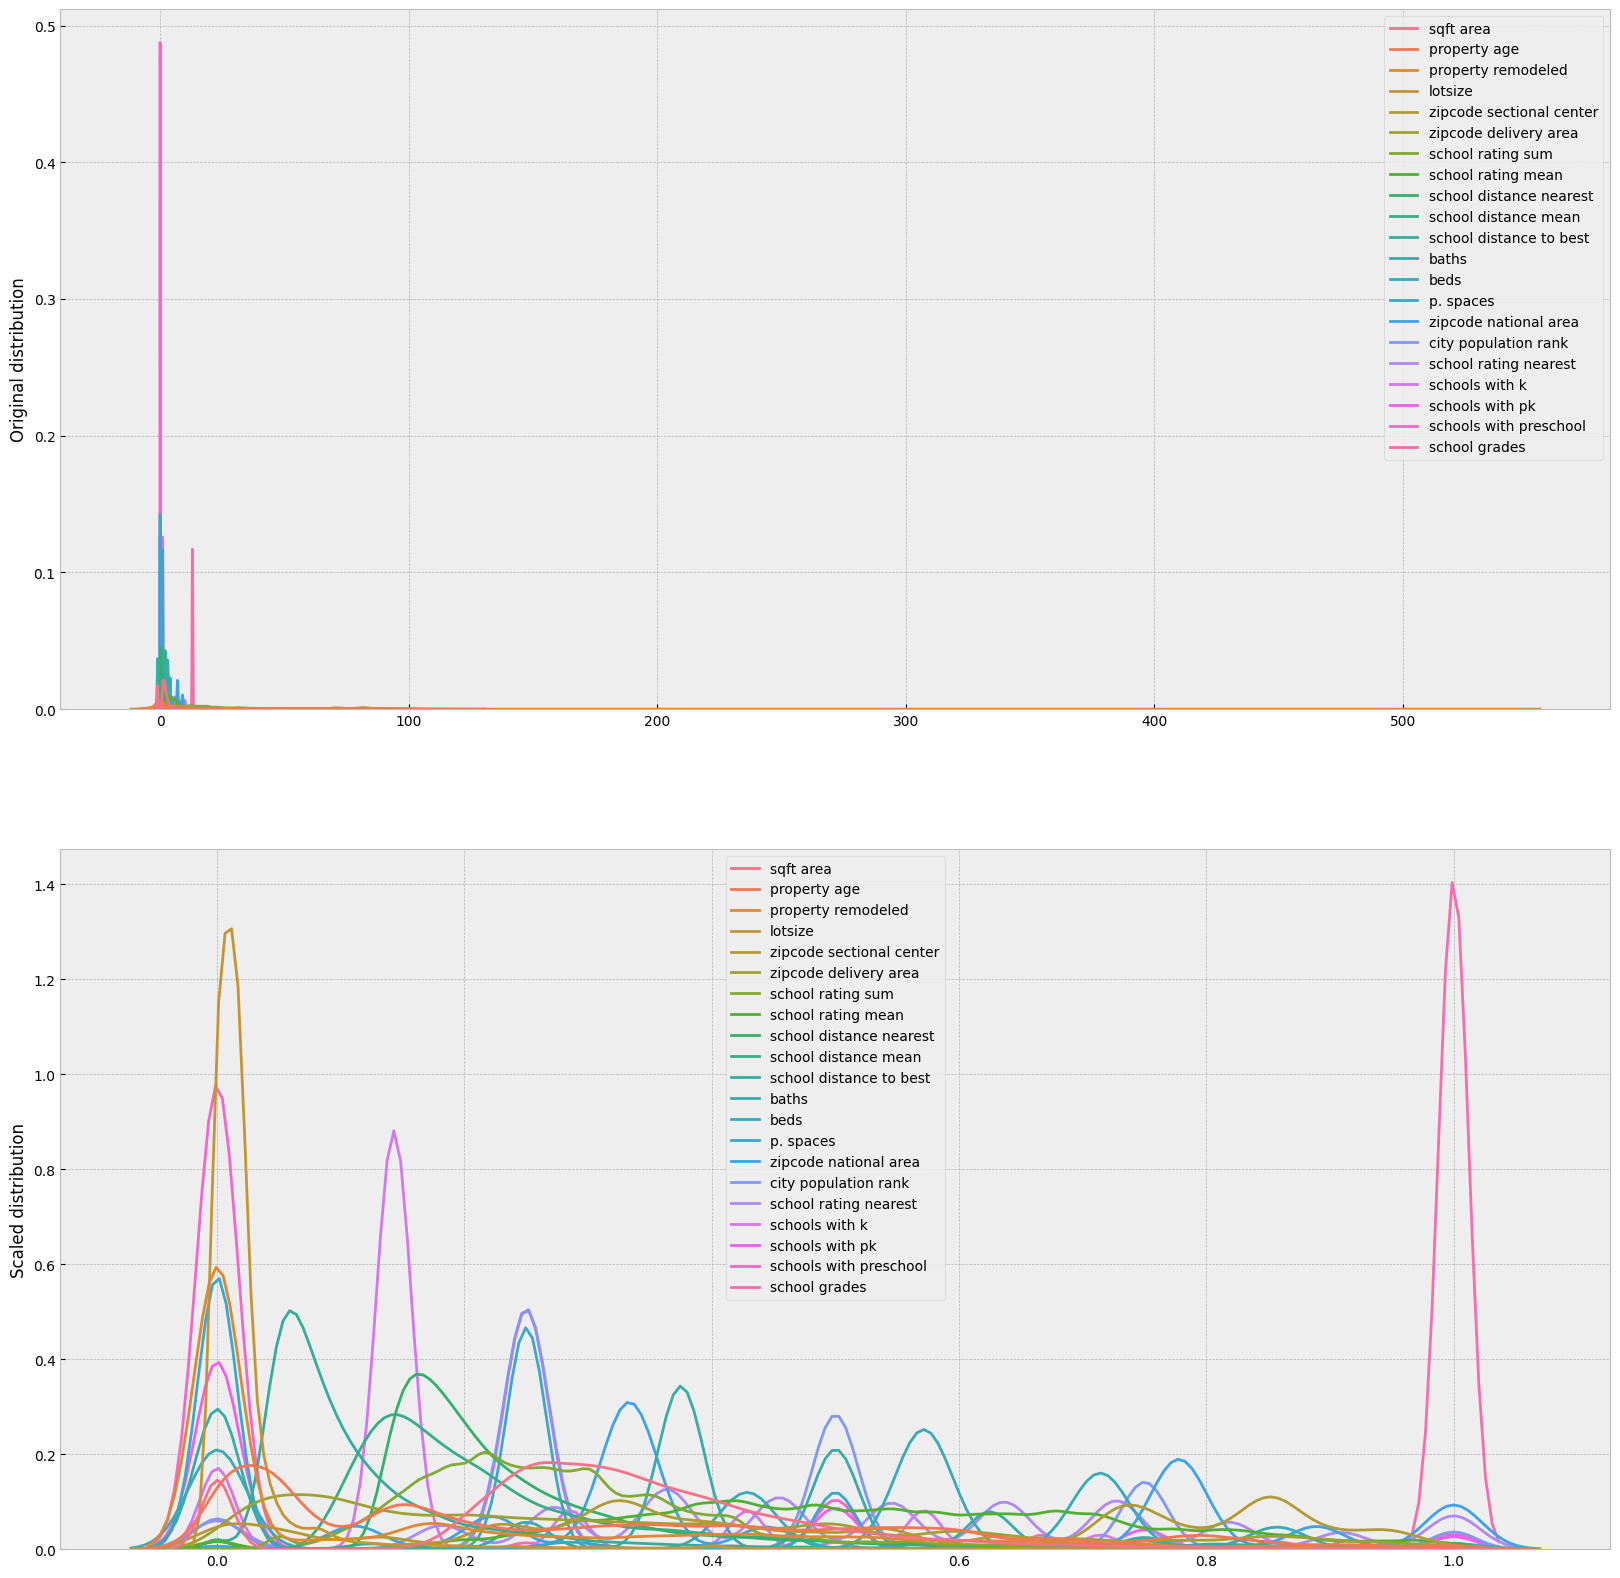

In [15]:
# все числовые переменные, которые нужно масштабировать
num_cols += cat_cols

# график со старыми и новыми данными
fig, ax = plt.subplots(2, 1, figsize=(20, 20))

sns.kdeplot(data[num_cols], ax=ax[0])
ax[0].set_ylabel('Original distribution')

scaler = pp.MinMaxScaler()
nums_scaled = pd.DataFrame(scaler.fit_transform(data[num_cols]),
                           columns=scaler.feature_names_in_)

sns.kdeplot(nums_scaled, ax=ax[1])
ax[1].set_ylabel('Scaled distribution')

fig.show()

> Теперь у нас получился идеальный датасет для обучения! Все данные в нем находятся в отрезке от 0 до 1. 

In [16]:
# загрузим обработанный датасет в отдельный файл, 
# чтобы сэкономить время на этапе моделирования
data[num_cols] = nums_scaled

data.to_csv('data/data_ultimate.csv', index=False)

## **Моделирование**

### Деление данных

Для обучения модели нужно разделить данные на обучающую и тестовую выборки. 

In [54]:
data = pd.read_csv('data/data_ultimate.csv')

# в данных есть пропуски в целевой переменной, обозначенные нулем
# выделим эти объекты в отдельную таблицу, она нам пригодится потом
X_eval = (data
          .query('target == 0')
          .drop('target', axis=1))

data.drop(X_eval.index, axis=0, inplace=True)

# выделяем для тестовой выборки 20% датасета
X = data.drop(['target'], axis=1)
y = data['target']

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, 
                                                       test_size=0.2, 
                                                       random_state=R)


X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_eval.shape

((243032, 124), (60758, 124), (243032,), (60758,), (1562, 124))

### Отбор самых сильных признаков

В данных очень много признаков, но не все из них важны для обучения. Отберем из них **пятину** признаков, которые вносят наибольший вклад в модель.

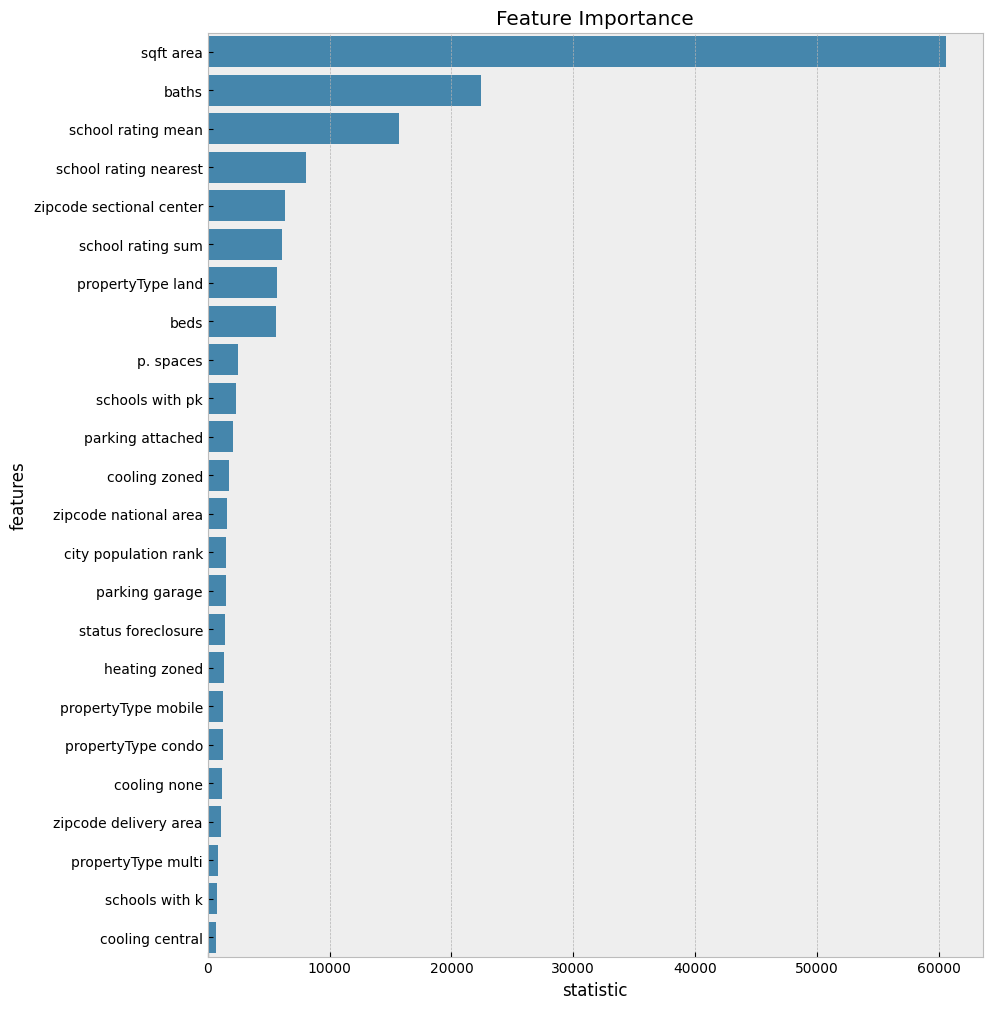

In [55]:
# отбираем признаки с помощью SelectKBest, применяем функцию для регрессии
k_best = X_train.shape[1] // 5

selector = fs.SelectKBest(score_func=fs.f_regression, k=k_best)
selector.fit(X_train, y_train)

# фильтруем данные
best_feats = selector.get_feature_names_out()

X_train = X_train[best_feats]
X_test = X_test[best_feats]
X_eval = X_eval[best_feats]

# выводим график с признаками
selector_scores = pd.DataFrame({'features': selector.feature_names_in_, 
                                'statistic': selector.scores_})

plt.figure(figsize=(10, 12))
sns.barplot(selector_scores.sort_values('statistic', ascending=False)[:k_best], 
            y='features', 
            x='statistic', 
            orient='h').set_title('Feature Importance')

plt.show()

### Подбор модели

Начинается этап подбора модели, которая наилучшим образом предсказывает результат. Подбирать я ее буду на основе трех метрик для регрессии:
- **MAE** - на сколько в среднем предсказания модели отличаются от реальных результатов (чем ниже, тем лучше).
- **MAPE** - на сколько процентов они отличаются (должна быть не выше 5%). 
- **R2** - насколько предсказание качественное по сравнению со средним арифметическим (должна быть больше 0.5).

Каждую метрику я буду высчитывать следующим образом:
- **_train** - на тренировочной выборке.
- **_test** - на тестовой выборке
- **_difference** - разница между этими метриками для отслеживания переобучения.

Итого получается **9** показателей.

In [159]:
# таблица с метриками и моделью
models = pd.DataFrame(columns=['MAE_train', 'MAE_test', 'MAE_difference', 
                               'MAPE_train', 'MAPE_test', 'MAPE_difference',
                               'R2_train', 'R2_test', 'R2_difference', 
                               'Model'])


def regression_estimate(model, 
                        X_train=X_train, 
                        y_train=y_train, 
                        X_test=X_test, 
                        y_test=y_test, 
                        params=None):
    """
    Функция для оценивания касечтва модели регрессии.
    
    - model: модель
    - X_train, X_test, y_train, y_test: выборки
    - params: если в функцию передается словарь с гиперпараметрами, 
        запускается механизм оптимизации и кросс-валидации.
    """
    # словарь с метриками и моделью
    metric_dict = {}
    
    # настройка гиперпараметров, возвращается лучшая модель
    if params is not None:
        rs = ms.RandomizedSearchCV(estimator=model, 
                                   param_distributions=params, 
                                   scoring='neg_mean_squared_error', 
                                   cv=10, 
                                   random_state=R, n_jobs=-1, verbose=1) 
        rs.fit(X_train, y_train)
        
        model = rs.best_estimator_
    
    else:
        model.fit(X_train, y_train)
    
    # обучение и предсказания
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    mae = lambda y, y_: m.mean_absolute_error(y, y_).round(2)
    """Элиас для `mean_absolute_error`"""
    
    mape = lambda y, y_: m.mean_absolute_percentage_error(y, y_).round(2)
    """Элиас для `mean_absolute_percentage_error`"""
    
    # средняя абсолютная ошибка
    metric_dict['MAE_train'] = mae(y_train, train_pred)
    metric_dict['MAE_test'] = mae(y_test, test_pred)
    metric_dict['MAE_difference'] = np.abs(metric_dict['MAE_train'] - 
                                           metric_dict['MAE_test']).round(2)
    
    # средняя абсолютная ошибка в процентах
    metric_dict['MAPE_train'] = mape(y_train, train_pred)
    metric_dict['MAPE_test'] = mape(y_test, test_pred)
    metric_dict['MAPE_difference'] = np.abs(metric_dict['MAPE_train'] - 
                                            metric_dict['MAPE_test']).round(2)
    
    # доля уловленной дисперсии
    metric_dict['R2_train'] = m.r2_score(y_train, train_pred).round(2)
    metric_dict['R2_test'] = m.r2_score(y_test, test_pred).round(2)
    metric_dict['R2_difference'] = np.abs(metric_dict['R2_train'] - 
                                          metric_dict['R2_test']).round(2)
    
    # модель
    metric_dict['Model'] = model
    
    return metric_dict


def add_metrics_model(model_name, metrics, data=models):    
    """
    Добавляет словарь с метриками в специальную таблицу.
    
    - model_name: название модели, добавляемый в индекс
    - metrics: словарь с метриками
    - data: специальная таблица
    """
    data.loc[model_name] = metrics
    
    return data


model_loc = lambda model: models.loc[model, 'Model']

models

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model


#### *Линейная регрессия (baseline)*

В качестве базовой модели возьмем простую линейную регрессию.

In [160]:
model = lm.LinearRegression(n_jobs=-1)
metrics = regression_estimate(model)

add_metrics_model('Linear', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,236.68,237.51,0.83,7.63,8.9,1.27,0.35,0.36,0.01,LinearRegression(n_jobs=-1)


> Пока выводов делать не будем, так как ее нужно сравнить с остальными моделями.

#### *Полиномиальная регрессия*

Попробуем добавить полиномиальные признаки, помогут ли они улучшить точность?

In [161]:
# добавляем признаки второй степени
polynom = pp.PolynomialFeatures(degree=2)
polynom.fit(X_train)

X_train_polynom = polynom.transform(X_train)
X_test_polynom = polynom.transform(X_test)

# размер новых данных
print(X_train_polynom.shape, X_test_polynom.shape)

metrics = regression_estimate(model, 
                              X_train=X_train_polynom, 
                              X_test=X_test_polynom)

add_metrics_model('Polynomial', metrics)

(243032, 325) (60758, 325)


,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,236.68,237.51,0.83,7.63,8.90,1.27,0.35,0.36,0.01,LinearRegression(n_jobs=-1)
Polynomial,187.27,186.65,0.62,6.69,4.56,2.13,0.54,0.55,0.01,LinearRegression(n_jobs=-1)


> Полиномиальные признаки помогли улучшить качество.

### Подбор модели с параметрами

Рассмотрим более сложные модели, где необходимо подбирать внешние параметры.

#### *Стохастический градиентный спуск*

Использует итеративный подбор внутренних параметров модели с помощью градиентного спуска.

In [162]:
model = lm.SGDRegressor(random_state=R)
metrics = regression_estimate(model)

add_metrics_model('SGD', metrics).loc[['SGD']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
SGD,236.18,237.04,0.86,7.61,8.77,1.16,0.35,0.36,0.01,SGDRegressor(random_state=314)


> Попробуем подобрать внешние параметры модели.
> * число итераций
> * шаг спуска - уменьшающийся или постоянный
> * размер шага 

In [163]:
params = {'max_iter': [1000, 1e4], 
          'learning_rate': ['invscaling', 'constant'], 
          'eta0': [0.01, 0.001, 0.0001]}

metrics = regression_estimate(model, params=params)

add_metrics_model('SGD', metrics)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,236.68,237.51,0.83,7.63,8.90,1.27,0.35,0.36,0.01,LinearRegression(n_jobs=-1)
Polynomial,187.27,186.65,0.62,6.69,4.56,2.13,0.54,0.55,0.01,LinearRegression(n_jobs=-1)
SGD,237.02,237.86,0.84,7.64,8.87,1.23,0.35,0.36,0.01,"SGDRegressor(eta0=0.001, random_state=314)"


> СГС не сильно отличается от обычной Линейной регрессии.

#### *Дерево решений*

Дерево как правило лучше справляется с прогнозом, когда распределение данных нелинейное.

In [164]:
model = tree.DecisionTreeRegressor(random_state=R)
metrics = regression_estimate(model)

add_metrics_model('Decision Tree', metrics).loc[['Decision Tree']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Decision Tree,7.36,129.5,122.14,3.66,0.75,2.91,0.99,0.62,0.37,DecisionTreeRegressor(random_state=314)


> Явное переобучение. Настроим параметры.
> * максимальный рост дерева 
> * минимальное число выборок для разделения вершин
> * минимальное число выборок в листьях дерева

In [165]:
params = {'max_depth': [6, 8, 10], 
          'min_samples_split': [1, 2, 3], 
          'min_samples_leaf': [1, 2, 3, 4]}

metrics = regression_estimate(model, params=params)

add_metrics_model('Decision Tree', metrics)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,236.68,237.51,0.83,7.63,8.90,1.27,0.35,0.36,0.01,LinearRegression(n_jobs=-1)
Polynomial,187.27,186.65,0.62,6.69,4.56,2.13,0.54,0.55,0.01,LinearRegression(n_jobs=-1)
SGD,237.02,237.86,0.84,7.64,8.87,1.23,0.35,0.36,0.01,"SGDRegressor(eta0=0.001, random_state=314)"
Decision Tree,160.51,165.25,4.74,8.56,6.17,2.39,0.65,0.62,0.03,"DecisionTreeRegressor(max_depth=10, min_sample..."


> Дерево превзошло результаты Полиномиальной регрессии. 

#### *Случайный лес*

А что если таких Деревьев будет много? Попробуем построить из них Случайный лес.

In [166]:
model = ens.RandomForestRegressor(random_state=R, n_jobs=-1)
metrics = regression_estimate(model)

add_metrics_model('Random Forest', metrics).loc[['Random Forest']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Random Forest,42.91,104.68,61.77,5.73,2.19,3.54,0.96,0.79,0.17,"(DecisionTreeRegressor(max_features=1.0, rando..."


> Явное переобучение. Настроим параметры (без случайного поиска, ибо уходит очень много времени и не так эффективно). Пусть количество деревьев будет 300, а остальные параметры - как у предыдущей модели.

In [167]:
# посмотрим, какие параметры были у Дерева
model_loc('Decision Tree').get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 314,
 'splitter': 'best'}

In [168]:
model = ens.RandomForestRegressor(n_estimators=300, 
                                  max_depth=10,
                                  min_samples_leaf=3,
                                  min_samples_split=3,
                                  random_state=R, n_jobs=-1)

metrics = regression_estimate(model)

add_metrics_model('Random Forest', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,236.68,237.51,0.83,7.63,8.90,1.27,0.35,0.36,0.01,LinearRegression(n_jobs=-1)
Polynomial,187.27,186.65,0.62,6.69,4.56,2.13,0.54,0.55,0.01,LinearRegression(n_jobs=-1)
SGD,237.02,237.86,0.84,7.64,8.87,1.23,0.35,0.36,0.01,"SGDRegressor(eta0=0.001, random_state=314)"
Decision Tree,160.51,165.25,4.74,8.56,6.17,2.39,0.65,0.62,0.03,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,148.94,153.66,4.72,8.49,6.32,2.17,0.70,0.67,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."


> Отлично! Качество предсказаний только растет.

#### *Стекинг*

А теперь попробуем сложить несколько моделей, чтобы они работали вместе, так должно быть эффективнее. Пусть это будет Линейная регрессия, СГС и Дерево решений, а метамоделью будет Случайный лес.

In [169]:
estimators = [('lr', model_loc('Linear')), 
              ('sgd', model_loc('SGD')), 
              ('dt', model_loc('Decision Tree'))]

final_estimator = ens.RandomForestRegressor(max_depth=10, random_state=R)

model = ens.StackingRegressor(estimators=estimators, 
                              final_estimator=final_estimator, 
                              cv=10, n_jobs=-1)

metrics = regression_estimate(model)

add_metrics_model('Stacking', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,236.68,237.51,0.83,7.63,8.90,1.27,0.35,0.36,0.01,LinearRegression(n_jobs=-1)
Polynomial,187.27,186.65,0.62,6.69,4.56,2.13,0.54,0.55,0.01,LinearRegression(n_jobs=-1)
SGD,237.02,237.86,0.84,7.64,8.87,1.23,0.35,0.36,0.01,"SGDRegressor(eta0=0.001, random_state=314)"
Decision Tree,160.51,165.25,4.74,8.56,6.17,2.39,0.65,0.62,0.03,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,148.94,153.66,4.72,8.49,6.32,2.17,0.70,0.67,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,157.64,162.20,4.56,8.22,6.26,1.96,0.66,0.63,0.03,"StackingRegressor(cv=10,\n es..."


> Стекинг не показал лучшей эффективности по сравнению со Случайным лесом. 

### Бустинг

Настало время для продвинутых моделей. Используем бустинг. 

Суть бустинга состоит в последовательном использовании слабых моделей, каждая из которых обучается и концентрируется на ошибках предыдущей, таким образом оттачивая свою точность, и в итоге получается сильная модель.

#### *Адаптивный бустинг*

In [170]:
model = ens.AdaBoostRegressor(random_state=R)
metrics = regression_estimate(model)

add_metrics_model('Adaptive Boosting', metrics).loc[['Adaptive Boosting']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Adaptive Boosting,356.82,356.25,0.57,19.92,12.18,7.74,0.12,0.14,0.02,"(DecisionTreeRegressor(max_depth=3, random_sta..."


> Слишком плохие показатели, нужно настроить.

In [171]:
model = ens.AdaBoostRegressor(estimator=model_loc('Decision Tree'), 
                              n_estimators=300,  
                              random_state=R)

metrics = regression_estimate(model)

add_metrics_model('Adaptive Boosting', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,236.68,237.51,0.83,7.63,8.90,1.27,0.35,0.36,0.01,LinearRegression(n_jobs=-1)
Polynomial,187.27,186.65,0.62,6.69,4.56,2.13,0.54,0.55,0.01,LinearRegression(n_jobs=-1)
SGD,237.02,237.86,0.84,7.64,8.87,1.23,0.35,0.36,0.01,"SGDRegressor(eta0=0.001, random_state=314)"
Decision Tree,160.51,165.25,4.74,8.56,6.17,2.39,0.65,0.62,0.03,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,148.94,153.66,4.72,8.49,6.32,2.17,0.70,0.67,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,157.64,162.20,4.56,8.22,6.26,1.96,0.66,0.63,0.03,"StackingRegressor(cv=10,\n es..."
Adaptive Boosting,486.70,491.54,4.84,27.83,17.96,9.87,-0.36,-0.38,0.02,"(DecisionTreeRegressor(max_depth=10, min_sampl..."


> Адаптивный бустинг, откровенно говоря, не справился.

#### *Градиентный бустинг*

In [172]:
model = ens.GradientBoostingRegressor(random_state=R)
metrics = regression_estimate(model)

add_metrics_model('Gradient Boosting', metrics).loc[['Gradient Boosting']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Gradient Boosting,169.04,168.88,0.16,7.91,6.52,1.39,0.6,0.6,0.0,([DecisionTreeRegressor(criterion='friedman_ms...


> Проверим, можно ли улучшить качество?

In [173]:
model = ens.GradientBoostingRegressor(n_estimators=300, 
                                      criterion='squared_error',
                                      max_depth=3, 
                                      random_state=R)

metrics = regression_estimate(model)

add_metrics_model('Gradient Boosting', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,236.68,237.51,0.83,7.63,8.90,1.27,0.35,0.36,0.01,LinearRegression(n_jobs=-1)
Polynomial,187.27,186.65,0.62,6.69,4.56,2.13,0.54,0.55,0.01,LinearRegression(n_jobs=-1)
SGD,237.02,237.86,0.84,7.64,8.87,1.23,0.35,0.36,0.01,"SGDRegressor(eta0=0.001, random_state=314)"
Decision Tree,160.51,165.25,4.74,8.56,6.17,2.39,0.65,0.62,0.03,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,148.94,153.66,4.72,8.49,6.32,2.17,0.70,0.67,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,157.64,162.20,4.56,8.22,6.26,1.96,0.66,0.63,0.03,"StackingRegressor(cv=10,\n es..."
Adaptive Boosting,486.70,491.54,4.84,27.83,17.96,9.87,-0.36,-0.38,0.02,"(DecisionTreeRegressor(max_depth=10, min_sampl..."
Gradient Boosting,155.20,155.48,0.28,7.17,5.05,2.12,0.65,0.65,0.00,"([DecisionTreeRegressor(max_depth=3,\n ..."


> Градиентный бустинг оказался даже лучше, чем Стекинг по МАЕ и Случайный лес по МАРЕ вместе взятые.

#### *Бустинг-регрессия от `xgboost`*

In [174]:
model = xgb.XGBRegressor()
metrics = regression_estimate(model)

add_metrics_model('XGBoost', metrics).loc[['XGBoost']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
XGBoost,123.23,129.23,6.0,7.16,1.1,6.06,0.77,0.75,0.02,"XGBRegressor(base_score=None, booster=None, ca..."


> Хороший показатель МАЕ, но по МАРЕ наблюдается переобучение.

In [175]:
model = xgb.XGBRegressor(n_estimators=300, 
                         max_depth=3, 
                         eta=0.3,
                         random_state=R, n_jobs=-1)

metrics = regression_estimate(model)

add_metrics_model('XGBoost', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,236.68,237.51,0.83,7.63,8.90,1.27,0.35,0.36,0.01,LinearRegression(n_jobs=-1)
Polynomial,187.27,186.65,0.62,6.69,4.56,2.13,0.54,0.55,0.01,LinearRegression(n_jobs=-1)
SGD,237.02,237.86,0.84,7.64,8.87,1.23,0.35,0.36,0.01,"SGDRegressor(eta0=0.001, random_state=314)"
Decision Tree,160.51,165.25,4.74,8.56,6.17,2.39,0.65,0.62,0.03,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,148.94,153.66,4.72,8.49,6.32,2.17,0.70,0.67,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,157.64,162.20,4.56,8.22,6.26,1.96,0.66,0.63,0.03,"StackingRegressor(cv=10,\n es..."
Adaptive Boosting,486.70,491.54,4.84,27.83,17.96,9.87,-0.36,-0.38,0.02,"(DecisionTreeRegressor(max_depth=10, min_sampl..."
Gradient Boosting,155.20,155.48,0.28,7.17,5.05,2.12,0.65,0.65,0.00,"([DecisionTreeRegressor(max_depth=3,\n ..."
XGBoost,142.64,143.68,1.04,6.71,3.86,2.85,0.70,0.70,0.00,"XGBRegressor(base_score=None, booster=None, ca..."


> Качество растет. Посмотрим, можно ли еще лучше?

#### *Регрессия от `LightGBM`*

In [176]:
model = lgbm.LGBMRegressor(random_state=R, n_jobs=-1)
metrics = regression_estimate(model)

add_metrics_model('LightGBM', metrics).loc[['LightGBM']]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 243032, number of used features: 24
[LightGBM] [Info] Start training from score 450.520754


,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
LightGBM,140.02,141.04,1.02,7.5,4.68,2.82,0.71,0.71,0.0,"LGBMRegressor(n_jobs=-1, random_state=314)"


> Проверим качество после настройки параметров.

In [177]:
model = lgbm.LGBMRegressor(n_estimators=300, 
                           max_depth=10, 
                           num_leaves=30, 
                           random_state=R, n_jobs=-1)

metrics = regression_estimate(model)

add_metrics_model('LightGBM', metrics)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 243032, number of used features: 24
[LightGBM] [Info] Start training from score 450.520754


,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,236.68,237.51,0.83,7.63,8.90,1.27,0.35,0.36,0.01,LinearRegression(n_jobs=-1)
Polynomial,187.27,186.65,0.62,6.69,4.56,2.13,0.54,0.55,0.01,LinearRegression(n_jobs=-1)
SGD,237.02,237.86,0.84,7.64,8.87,1.23,0.35,0.36,0.01,"SGDRegressor(eta0=0.001, random_state=314)"
Decision Tree,160.51,165.25,4.74,8.56,6.17,2.39,0.65,0.62,0.03,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,148.94,153.66,4.72,8.49,6.32,2.17,0.70,0.67,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,157.64,162.20,4.56,8.22,6.26,1.96,0.66,0.63,0.03,"StackingRegressor(cv=10,\n es..."
Adaptive Boosting,486.70,491.54,4.84,27.83,17.96,9.87,-0.36,-0.38,0.02,"(DecisionTreeRegressor(max_depth=10, min_sampl..."
Gradient Boosting,155.20,155.48,0.28,7.17,5.05,2.12,0.65,0.65,0.00,"([DecisionTreeRegressor(max_depth=3,\n ..."
XGBoost,142.64,143.68,1.04,6.71,3.86,2.85,0.70,0.70,0.00,"XGBRegressor(base_score=None, booster=None, ca..."
LightGBM,125.41,128.78,3.37,6.87,3.72,3.15,0.76,0.75,0.01,"LGBMRegressor(max_depth=10, n_estimators=300, ..."


> Показатели МАЕ, по сравнению с Линейной регрессией, удалось уменьшить почти в 2 раза!

#### *Регрессия от `CatBoost`*

In [178]:
model = cb.CatBoostRegressor(random_state=R, verbose=False)
metrics = regression_estimate(model)

add_metrics_model('CatBoost', metrics).loc[['CatBoost']]

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
CatBoost,122.83,126.07,3.24,7.41,1.69,5.72,0.77,0.75,0.02,<catboost.core.CatBoostRegressor object at 0x0...


> По МАРЕ видно переобучение, его нужно преодолеть.

In [179]:
model = cb.CatBoostRegressor(learning_rate=0.1, 
                             max_depth=5,
                             n_estimators=300,  
                             random_state=R, verbose=False)

metrics = regression_estimate(model)

add_metrics_model('CatBoost', metrics)

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
Linear,236.68,237.51,0.83,7.63,8.90,1.27,0.35,0.36,0.01,LinearRegression(n_jobs=-1)
Polynomial,187.27,186.65,0.62,6.69,4.56,2.13,0.54,0.55,0.01,LinearRegression(n_jobs=-1)
SGD,237.02,237.86,0.84,7.64,8.87,1.23,0.35,0.36,0.01,"SGDRegressor(eta0=0.001, random_state=314)"
Decision Tree,160.51,165.25,4.74,8.56,6.17,2.39,0.65,0.62,0.03,"DecisionTreeRegressor(max_depth=10, min_sample..."
Random Forest,148.94,153.66,4.72,8.49,6.32,2.17,0.70,0.67,0.03,"(DecisionTreeRegressor(max_depth=10, max_featu..."
Stacking,157.64,162.20,4.56,8.22,6.26,1.96,0.66,0.63,0.03,"StackingRegressor(cv=10,\n es..."
Adaptive Boosting,486.70,491.54,4.84,27.83,17.96,9.87,-0.36,-0.38,0.02,"(DecisionTreeRegressor(max_depth=10, min_sampl..."
Gradient Boosting,155.20,155.48,0.28,7.17,5.05,2.12,0.65,0.65,0.00,"([DecisionTreeRegressor(max_depth=3,\n ..."
XGBoost,142.64,143.68,1.04,6.71,3.86,2.85,0.70,0.70,0.00,"XGBRegressor(base_score=None, booster=None, ca..."
LightGBM,125.41,128.78,3.37,6.87,3.72,3.15,0.76,0.75,0.01,"LGBMRegressor(max_depth=10, n_estimators=300, ..."


> Результат очень схожий на результаты XGBoost, но MAPE немного хуже.

> На этом можно завершить подбор моделей, так как сомневаюсь, что после использования бустинга мы найдем модели лучше.

### Выбор модели 

Хорошей моделью считается та модель, у которой показатель МАРЕ ниже 5% и метрика R2 выше 0.5, и соответственно самый низкий МАЕ.

In [192]:
pick_model = (models
              .query('(R2_test >= 0.5) & (MAPE_test <= 5)')
              .sort_values('MAE_test'))

pick_model

,MAE_train,MAE_test,MAE_difference,MAPE_train,MAPE_test,MAPE_difference,R2_train,R2_test,R2_difference,Model
LightGBM,125.41,128.78,3.37,6.87,3.72,3.15,0.76,0.75,0.01,"LGBMRegressor(max_depth=10, n_estimators=300, ..."
XGBoost,142.64,143.68,1.04,6.71,3.86,2.85,0.70,0.70,0.00,"XGBRegressor(base_score=None, booster=None, ca..."
CatBoost,145.29,145.75,0.46,7.80,4.50,3.30,0.69,0.69,0.00,<catboost.core.CatBoostRegressor object at 0x0...
Polynomial,187.27,186.65,0.62,6.69,4.56,2.13,0.54,0.55,0.01,LinearRegression(n_jobs=-1)


Лучшая модель: 
LGBMRegressor(max_depth=10, n_estimators=300, n_jobs=-1, num_leaves=30,
              random_state=314)


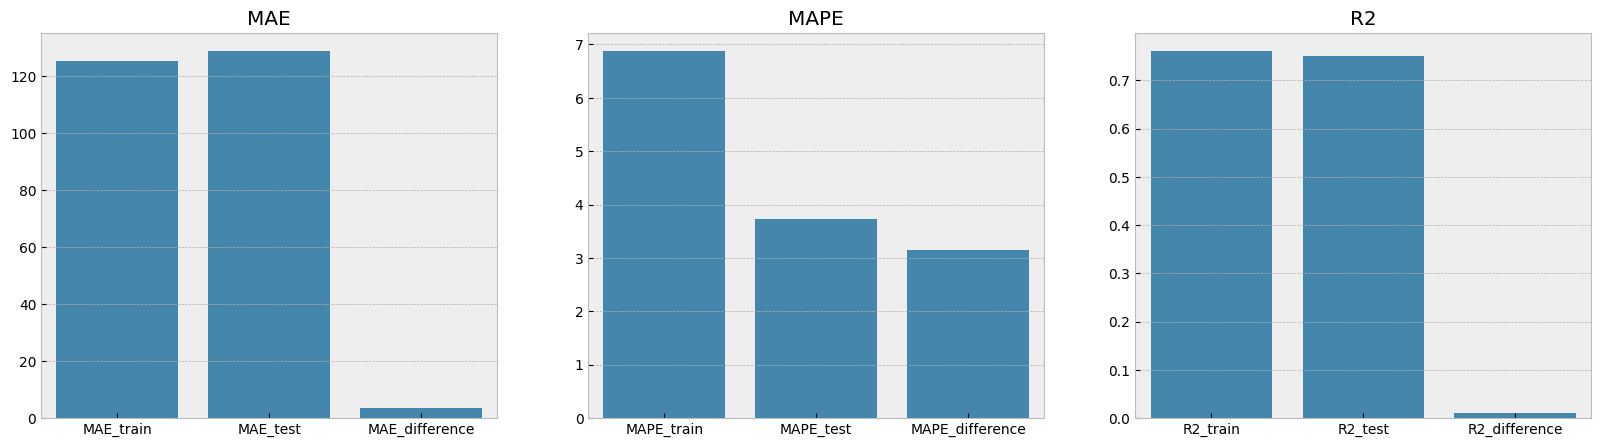

In [193]:
# выбор лучшей модели 
best_model = pick_model.iloc[0]['Model']

print(f'Лучшая модель: \n{best_model}')


slice_dict = lambda dict_, first=None, last=None: {key: dict_[key] 
                                                   for key in list(dict_.keys())
                                                   [first:last]}
"""Функция позволяет делать срезы у словарей"""

def show_metrics(dict_):    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    sns.barplot(slice_dict(dict_, first=0, last=3), ax=ax[0])
    ax[0].set_title('MAE')
    
    sns.barplot(slice_dict(dict_, first=3, last=6), ax=ax[1])
    ax[1].set_title('MAPE')

    sns.barplot(slice_dict(dict_, first=6, last=-1), ax=ax[2])
    ax[2].set_title('R2')
   
    fig.show()


show_metrics(pick_model.iloc[0].to_dict())

> Итого, самой лучшей моделью является модель `LightGBM Regressor` с максимальной глубиной `10`, количеством базовых моделей `300` и числом листьев `30` (кстати, random_state тоже немаловажен, такие показатели были достигнуты при этом параметре равном `314`). 

## **Загрузка моделей и вывод в продакшн**

Теперь данную модель можно использовать в деле. Например создать веб-сервис, который принимает данные и выдает приблизительную цену на недвижимость на их основе. Данный сервис я собираюсь сделать в папке `/app`. 

In [194]:
# эти датасеты нужны для работы приложения
X_eval.to_csv('app/data/x_eval.csv', index=False)

y_eval = pd.Series(best_model.predict(X_eval))
y_eval.to_csv('app/data/y_eval.csv', index=False)

# загружаем модель в pickle
with open('app/models/model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)
    
print("Работа завершена!")

Работа завершена!
